# Terceiro Trabalho - Previsão de Localização de Ônibus

#### Senha utilizada para a submissão das respostas: dm_trab3_ly

## Preparação arquivos de dados

### Arquivos de treinamento

In [1]:
from zipfile import ZipFile
from pathlib import Path

import pandas as pd

- Extração dos dados em uma pasta por dia
- Dentro de cada pasta vários arquivos json para um único dia

In [ ]:
# 'data_raw' - diretório com os arquivos originais baixados

data_dir = Path('data_raw')

for zip_file in data_dir.iterdir():
    with ZipFile(zip_file, 'r') as zf:
        zf.extractall(path=data_dir)

- Transformação das pastas com diversos arquivos por dia em um único arquivo por dia no formato csv

In [ ]:
# arquivos estão no diretório 'tempdir'

work_dir = data_dir/'tempdir'

for gps_day in work_dir.iterdir():
    df = pd.DataFrame()
    for json_file in gps_day.iterdir():
        df_gps = pd.read_json(json_file)
        df = pd.concat([df, df_gps])
    df.to_csv(data_dir/f'{gps_day.stem}.csv', index=False)

- Filtragem das linhas de interesse
- Remoção da variável 'datahoraenvio', remoção de dados duplicados, transformação do formato das coordenadas
- Variável 'datahoraservidor' como time index

In [2]:
linhas_alvo = ['483', '864', '639', '3', '309', '774', '629', '371', '397', '100', '838', '315', 
          '624', '388', '918', '665', '328', '497', '878', '355', '138', '606', '457', '550', 
          '803', '917', '638', '2336', '399', '298', '867', '553', '565', '422', '756', 
          '186012003', '292', '554', '634', '232', '415', '2803', '324', '852', '557',
          '759', '343', '779', '905', '108']

def filter_and_transform(df):
    #remove
    #print(f'Número de linhas antes: {len(df)}')
    df = df.drop('datahoraenvio', axis=1)
    df = df[df.linha.isin(linhas_alvo)]
    df = df.drop_duplicates(subset=['ordem', 'datahoraservidor'])
    #print(f'Número de linhas depois: {len(df)}')

    #transforma
    df['latitude'] = df['latitude'].str.replace(',', '.').astype(float)
    df['longitude'] = df['longitude'].str.replace(',', '.').astype(float)
    df['data_index'] = pd.to_datetime(df['datahoraservidor'], unit='ms')
    df = df.set_index('data_index')
    df = df.drop('datahoraservidor', axis=1)
    return df

- Criação de um arquivo único com todos os dados concatenados

In [ ]:
data_raw_dir = Path('data_raw')
data_dir = Path('data')
work_dir = data_raw_dir/'csvfiles'

df = pd.DataFrame() 
for csv_day in work_dir.iterdir():    
    df_day = pd.read_csv(csv_day)
    df_day = filter_and_transform(df_day)
    df = pd.concat([df, df_day])

df.to_csv(data_dir/'train.csv')

- Ordena pelo index e salva o arquivo novamente
- Todos os dados foram concatenados em um único arquivo "train.csv"

In [ ]:
data_dir = Path('data')
df = pd.read_csv(data_dir/'train.csv', index_col='data_index')
df = df.sort_index(axis=0)
df = df.loc[:, ['ordem', 'linha', 'latitude', 'longitude', 'velocidade', 'datahora']]
df.to_csv(data_dir/'train.csv')

### Arquivos de teste

- Extração dos arquivos .zip

In [ ]:
data_dir = Path('data_raw/zipfiles_test')

for zip_file in data_dir.iterdir():
    with ZipFile(zip_file, 'r') as zf:
        zf.extractall(path=data_dir)

- Os arquivos são concatenados de dois em dois (duas horas anteriores ao arquivo de teste)
- Os arquivos de teste e resposta também são contatenados
- Cada teste é composto por 2 arquivos (dados das últimas horas antes do teste e dados de teste)

In [ ]:
test_dir = Path('data/test')

day = '15'

d1 = f'{day}_21'
d2 = f'{day}_22'
dt = f'{day}_23'
target_dt = True

dtreino = f'D{day}_FILES_{d1.split('_')[-1]}_{d2.split('_')[-1]}_SUP.csv'
dteste = f'D{day}_FILES_{dt.split('_')[-1]}_TEST.csv'



df1 = pd.read_json(f'data_raw/tempdir/2024-05-{day}/2024-05-{d1}.json')
df2 = pd.read_json(f'data_raw/tempdir/2024-05-{day}/2024-05-{d2}.json')

df = pd.concat([df1, df2])
df = filter_and_transform(df)
df = df.loc[:, ['ordem', 'linha', 'latitude', 'longitude', 'velocidade', 'datahora']]
df = df.sort_index(axis=0)
df.to_csv(test_dir/dtreino)

df1 = pd.read_json(f'data_raw/tempdir/2024-05-{day}/treino-2024-05-{dt}.json')
df2 = pd.read_json(f'data_raw/tempdir/2024-05-{day}/resposta-2024-05-{dt}.json')

df_test = df1.merge(df2, how='left', on='id')
df_test = df_test.drop('id', axis=1)
df_test['latitude'] = df['latitude'].str.replace(',', '.').astype(float)
df_test['longitude'] = df['longitude'].str.replace(',', '.').astype(float)
df_test = df_test.loc[:, ['ordem', 'linha', 'latitude', 'longitude', 'datahora']]

if target_dt:
    df_test = df_test.rename(columns={'datahora':'datahora_target'})
else:
    df_test = df_test.rename(columns={'latitude':'latitude_target'})
    df_test = df_test.rename(columns={'longitude':'longitude_target'})

df_test.to_csv(test_dir/dteste)

- Preparação arquivos de teste para a submissão

In [23]:
test_dir = Path('data/test_final')

day = '20'

d1 = f'{day}_19'
d2 = f'{day}_20'
dt = f'{day}_21'
target_dt = True

dtreino = f'D{day}_FILES_{d1.split('_')[-1]}_{d2.split('_')[-1]}_TRAIN.csv'

dtest_target = 'DT' if target_dt else 'LATLONG'
dteste = f'D{day}_FILES_{dt.split('_')[-1]}_2024-05-{dt}_TEST_{dtest_target}.csv'

df1 = pd.read_json(f'data_raw/tempdir/final-2024-05-{day}/2024-05-{day}/2024-05-{d1}.json')
df2 = pd.read_json(f'data_raw/tempdir/final-2024-05-{day}/2024-05-{day}/2024-05-{d2}.json')

df = pd.concat([df1, df2])
df = filter_and_transform(df)
df = df.loc[:, ['ordem', 'linha', 'latitude', 'longitude', 'velocidade', 'datahora']]
df = df.sort_index(axis=0)
df.to_csv(test_dir/dtreino)

df_test = pd.read_json(f'data_raw/tempdir/final-2024-05-{day}/2024-05-{day}/teste-2024-05-{dt}.json')

if target_dt:
    df_test['latitude'] = df_test['latitude'].str.replace(',', '.').astype(float)
    df_test['longitude'] = df_test['longitude'].str.replace(',', '.').astype(float)
    df_test = df_test.loc[:, ['id', 'ordem', 'linha', 'latitude', 'longitude']]
else:
    df_test = df_test.loc[:, ['id', 'ordem', 'linha', 'datahora']]

df_test.to_csv(test_dir/dteste, index=False)

In [ ]:
file_name = 'data/test/D15_FILES_23_TEST.csv'
target_dt = True

df = pd.read_csv(file_name)

if target_dt:
    df['latitude'] = df['latitude'].str.replace(',', '.').astype(float)
    df['longitude'] = df['longitude'].str.replace(',', '.').astype(float)
else:
    df['latitude_target'] = df['latitude_target'].str.replace(',', '.').astype(float)
    df['longitude_target'] = df['longitude_target'].str.replace(',', '.').astype(float)
df.to_csv(file_name)

## Exploração dos dados

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import folium

In [2]:
def load_treino():
    data_dir = Path('data/treino')
    return pd.read_csv(data_dir/'train.csv', index_col='data_index', parse_dates=True)

def get_onibus(df, linha, ordem=None):
    if ordem is None:
        return df[df.linha==linha]
    return df[(df.linha == linha)&(df.ordem == ordem)]

- Descrição dos dados

In [3]:
df = load_treino()
df

,ordem,linha,latitude,longitude,velocidade,datahora
data_index,,,,,,
2024-04-25 03:00:06,A41002,100,-22.90086,-43.17884,9,1714013994000
2024-04-25 03:00:06,A41051,100,-22.87493,-43.24166,0,1714014001000
2024-04-25 03:00:06,C41244,309,-22.87499,-43.24137,0,1714014001000
2024-04-25 03:00:06,A41172,309,-22.87406,-43.24172,0,1714014003000
2024-04-25 03:00:06,A41238,315,-22.87519,-43.24080,0,1714013998000
...,...,...,...,...,...,...
2024-05-11 03:00:30,C30226,557,-22.99719,-43.31971,7,1715396389000
2024-05-11 03:00:30,D13370,878,-22.94846,-43.33918,0,1715396390000
2024-05-11 03:00:30,C47722,554,-22.96086,-43.17549,47,1715396388000


In [28]:
numero_linhas = len(df.linha.unique())
numero_ordens = len(df.ordem.unique())
data_inicio = df.index[0]
data_fim = df.index[-1]
velocidade_max = df.velocidade.max()
velocidade_min = df.velocidade.min()

print(f'Número de linhas: {numero_linhas}')
print(f'Número de ônibus: {numero_ordens}')
print(f'Data início: {data_inicio}')
print(f'Data fim: {data_fim}')
print(f'Velocidade máxima: {velocidade_max}km/h')
print(f'Velocidade mínima: {velocidade_min}km/h')

Número de linhas: 48
Número de ônibus: 2764
Data início: 2024-04-25 03:00:06
Data fim: 2024-05-11 03:00:39
Velocidade máxima: 150km/h
Velocidade mínima: 0km/h


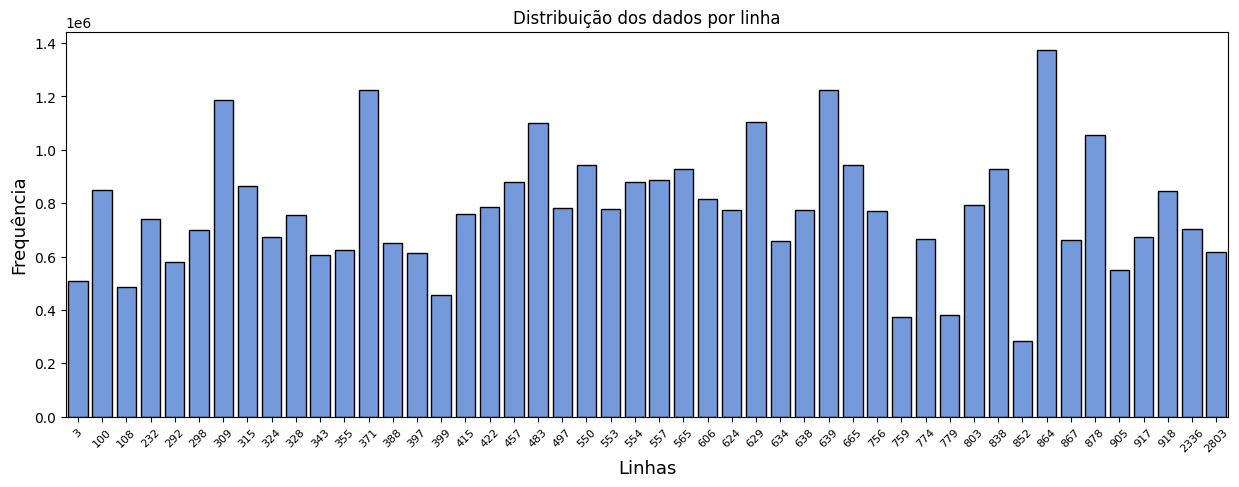

In [4]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(df, x='linha', ax=ax, color='cornflowerblue', linewidth=1, edgecolor='black')
#ax.bar_label(ax.containers[0], fontsize=8)
ax.set_title('Distribuição dos dados por linha')
ax.tick_params(axis='x', labelsize=8, labelrotation=45)
ax.set_xlabel('Linhas', fontsize=13)
ax.set_ylabel('Frequência', fontsize=13)
plt.show()


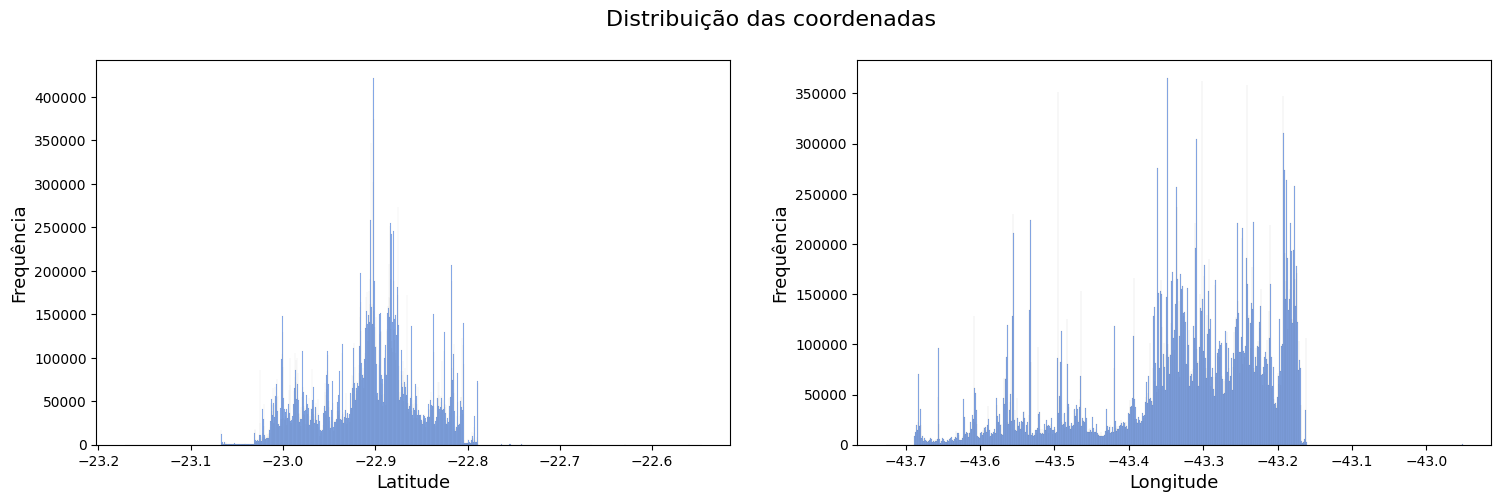

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Distribuição das coordenadas', fontsize=16)
sns.histplot(df, x='latitude', ax=ax1, color='cornflowerblue')
ax1.set_xlabel('Latitude', fontsize=13)
ax1.set_ylabel('Frequência', fontsize=13)
sns.histplot(df, x='longitude', ax=ax2, color='cornflowerblue')
ax2.set_xlabel('Longitude', fontsize=13)
ax2.set_ylabel('Frequência', fontsize=13)
plt.show()

Exemplo de trajetória  

- Plot dos pontos de GPS (linha 483, ordem B31075)

In [ ]:
df_map = get_onibus(df, linha=483, ordem='B31075')
map = folium.Map(location=[df_map.latitude.mean(), df_map.longitude.mean()], zoom_start=11.3, control_scale=True, width=800, height=550, tiles="cartodb positron")
for index, row in df_map.iterrows():
    folium.CircleMarker([row.latitude, row.longitude], radius=2, color='cornflowerblue', fill=True, fill_opacity=0.6, opacity=1, stroke=False).add_to(map)
del df_map
map

# Gerei o mapa interativo aqui mas botei como imagem para o arquivo do notebook não ficar muito grande. 

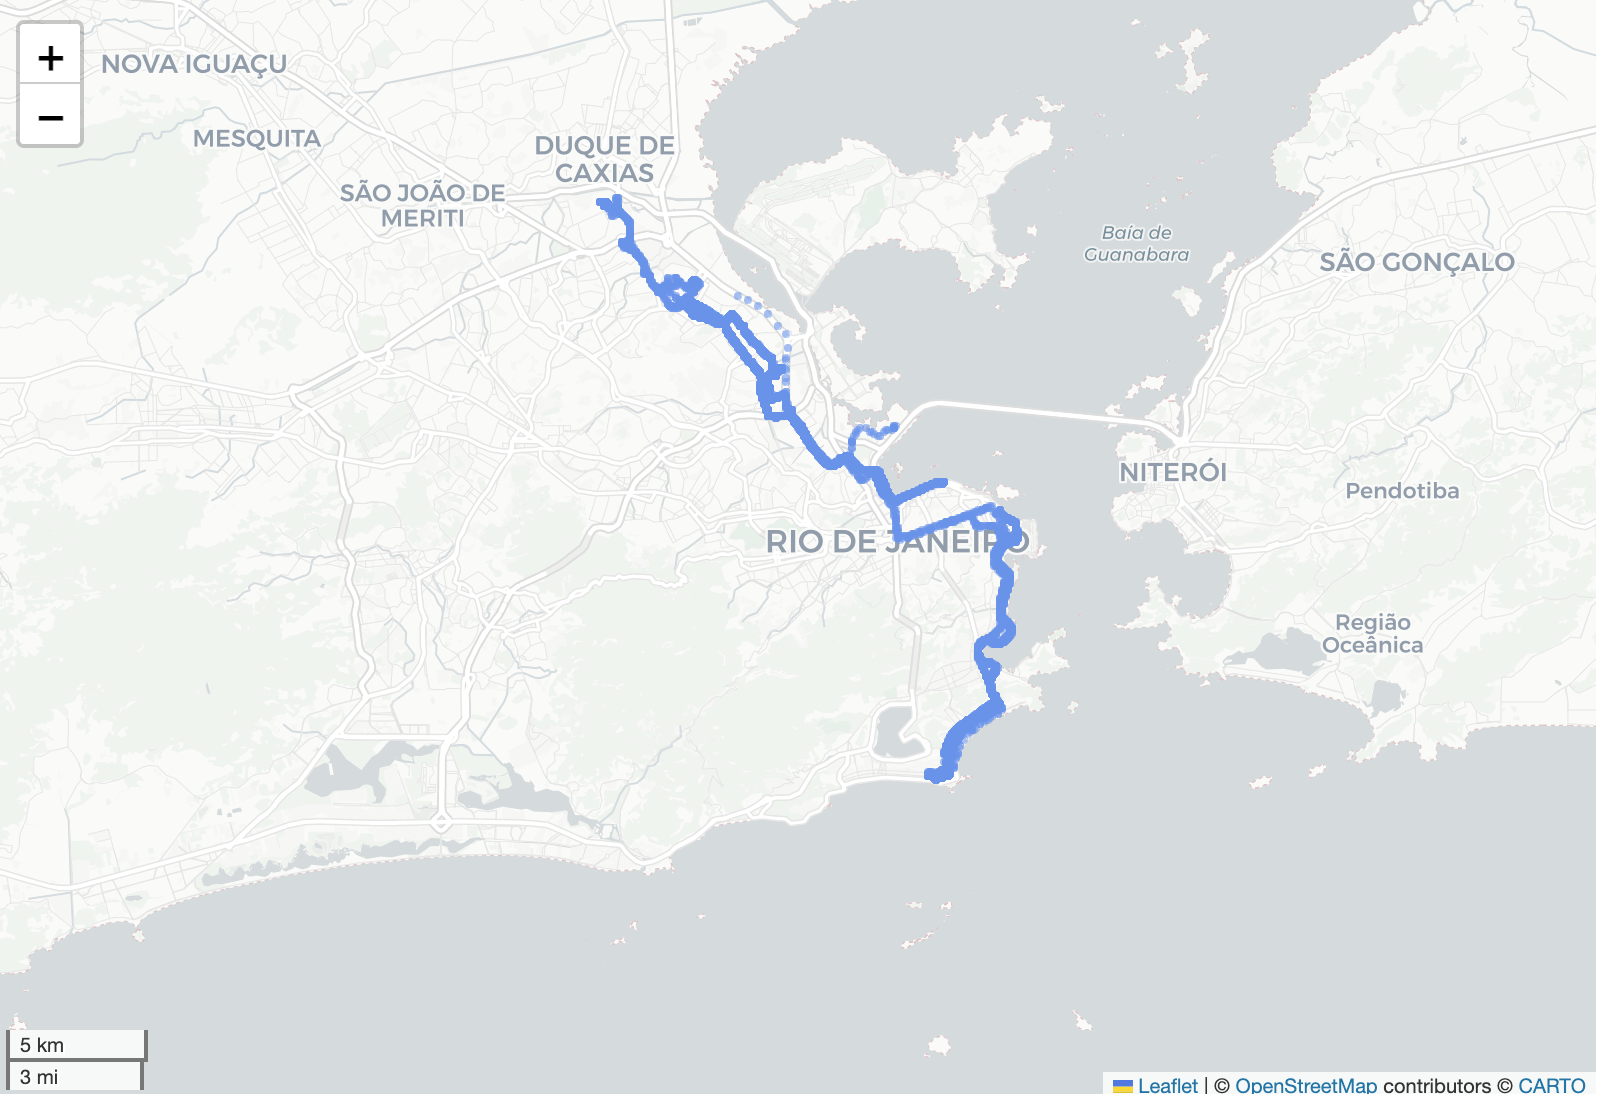

## Modelos

In [1]:
from pathlib import Path

from sklearn.metrics import root_mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from lightgbm.callback import early_stopping
from shapely.geometry import Point
from xgboost import XGBRegressor
import geopandas as gpd
import lightgbm as lgb
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

- Funções para o carregamento dos dados

In [2]:
def load_treino():
    data_dir = Path('data/treino')
    return pd.read_csv(data_dir/'train.csv', index_col='data_index', parse_dates=True)

def load_treino_filtrado():
    data_dir = Path('data/treino')
    return pd.read_csv(data_dir/'train_filtrado_garagem_pf.csv', index_col='data_index', parse_dates=True)

def load_data(file_path):
    return pd.read_csv(file_path, index_col='data_index', parse_dates=True)

def get_onibus(df, linha, ordem):
    return df[(df.linha == linha)&(df.ordem == ordem)]

def load_test_dt(file_path, data_index=True):
    df = pd.read_csv(file_path, usecols=['ordem','linha','latitude','longitude','datahora_target'])
    if data_index:
        df['data_index'] = pd.to_datetime(df['datahora_target'], unit='ms')
        df = df.set_index('data_index')
        df = df.sort_index(axis=0)
    return df

def load_test_latlong(file_path, data_index=True):
    df = pd.read_csv(file_path, usecols=['ordem','linha','latitude_target','longitude_target','datahora'])
    if data_index:
        df['data_index'] = pd.to_datetime(df['datahora'], unit='ms')
        df = df.set_index('data_index')
        df = df.sort_index(axis=0)
    return df

def load_final_test_dt(file_path):
    df = pd.read_csv(file_path, usecols=['id','ordem','linha','latitude','longitude'])
    return df

def load_final_test_latlong(file_path, data_index=True):
    df = pd.read_csv(file_path, usecols=['id', 'ordem','linha','datahora'])
    if data_index:
        df['data_index'] = pd.to_datetime(df['datahora'], unit='ms')
        df = df.set_index('data_index')
        df = df.sort_index(axis=0)
    return df



- Classes de transformação dos dados

In [3]:
class DataPipeline:

    def __init__(self, data_preprocessors):
        self.data_preprocessors = data_preprocessors
        self.lag_dt_config = None

    def set_lag_dt_config(self, lag_dt_config):
        self.lag_dt_config = lag_dt_config

    def add_transformation(self, transformation):
        self.data_preprocessors.append(transformation)
        
    def transform(self, data):
        for preprocessor, kws in self.data_preprocessors:
            data = preprocessor(data, **kws)
        return data


class DataPreprocessor:

    def filter_hour(self, df, h_start=None, h_end=None):
        if h_start is None and h_end is not None:
            df_filter = df.index.hour < h_end
        elif h_end is None and h_start is not None:
            df_filter = df.index.hour >= h_start
        else:
            df_filter = (df.index.hour >= h_start) & (df.index.hour < h_end)
        return df[df_filter]
    
    def filter_date(self, df, data_start=None, data_end=None):
        if data_start is None and data_end is not None:
            return df[:data_end]
        elif data_end is None and data_start is not None:
            return df[data_start:]
        else:
            return df[data_start:data_end]
        
    def apply_ordinal_encoder(self, df, column, Encoder, test=False):
        if self.encoder is None:
            self.encoder = Encoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int64)
        
        if test == False:
            df[column] = self.encoder.fit_transform(df[[column]])
        else:
            df[column] = self.encoder.transform(df[[column]])
        
        return df
    
    def lag_datahora_treino(self, df, lag_list):

        def shift_datahora(df, lag_list):
            for lag in lag_list:
                df[f'dt_lag_{lag}'] = df.datahora.shift(lag)
            return df
        
        df = df.groupby(['linha', 'ordem']).apply(shift_datahora, include_groups=False, lag_list=lag_list).reset_index().set_index('data_index').sort_index(axis=0)
        return df
    
    def lag_datahora_test(self, df, df_sup, lag_list):

        def shift_datahora(df, lag_list):
            for lag in lag_list:
                df[f'dt_lag_{lag}'] = df.datahora.shift(lag)
            return df
        
        df_sup = df_sup.drop('velocidade', axis=1).reset_index(drop=True)
        df_sup['test'] = 0

        df = df.reset_index(drop=True)
        df['datahora'] = np.nan
        df['test'] = 1

        df = pd.concat([df_sup, df])

        df = df.groupby(['linha', 'ordem']).apply(shift_datahora, include_groups=False, lag_list=lag_list).reset_index()
        df = df.loc[df.test == 1]
        df = df.drop(['datahora', 'test', 'level_2'], axis=1)
        return df
    
    def lag_lat_long_treino(self, df, lag_list):

        def shift_lat_long(df, lag_list):
            for lag in lag_list:
                df[f'lat_lag_{lag}'] = df.latitude.shift(lag)
                df[f'lat_long_{lag}'] = df.longitude.shift(lag)
            return df
        
        #df = df.groupby(['linha', 'ordem']).apply(shift_lat_long, include_groups=False, lag_list=lag_list).reset_index().set_index('data_index').sort_index(axis=0)
        df = df.groupby(['linha', 'ordem']).apply(shift_lat_long, include_groups=False, lag_list=lag_list).reset_index().set_index('data_index')
        return df
    
    def lag_lat_long_teste(self, df, df_sup, lag_list):
        
        def shift_lat_long(df, lag_list):
            for lag in lag_list:
                df[f'lat_lag_{lag}'] = df.latitude.shift(lag)
                df[f'lat_long_{lag}'] = df.longitude.shift(lag)
            return df
        
        df_sup = df_sup.drop('velocidade', axis=1).reset_index(drop=True)
        df_sup['test'] = 0

        df = df.reset_index(drop=True)
        df['datahora'] = np.nan
        df['test'] = 1

        df = pd.concat([df_sup, df])

        df = df.groupby(['linha', 'ordem']).apply(shift_lat_long, include_groups=False, lag_list=lag_list).reset_index()
        df = df.loc[df.test == 1]
        df = df.drop(['datahora', 'test', 'level_2'], axis=1)
        return df  
    
    def add_time_features_treino(self, df):
        df['day_of_year'] = df.index.dayofyear.astype("int16")
        df['day_of_month'] = df.index.day.astype("int8")
        df['day_of_week'] = (df.index.dayofweek + 1).astype("int8")
        df['weekend'] = (df.index.weekday // 5).astype("int8")
        #df['sunday'] = (df.index.weekday // 6).astype("int8")
        df['hour_of_day'] = df.index.hour.astype("int8")
        return df
    
    def add_time_features_dt_teste(self, df, df_sup):
        df['day_of_year'] = df_sup.index[-1].dayofyear
        df['day_of_month'] = df_sup.index[-1].day
        df['day_of_week'] = (df_sup.index[-1].dayofweek + 1)
        df['weekend'] = (df_sup.index[-1].weekday() // 5)
        df['hour_of_day'] = df_sup.index[-1].hour
        return df
    
    def add_time_features_latlong_teste(self, df):
        df['day_of_year'] = df.index.dayofyear.astype("int16")
        df['day_of_month'] = df.index.day.astype("int8")
        df['day_of_week'] = (df.index.dayofweek + 1).astype("int8")
        df['weekend'] = (df.index.weekday // 5).astype("int8")
        df['hour_of_day'] = df.index.hour.astype("int8")
        return df

    def add_lag_distances_treino(self, df):
        geometry = [Point(x,y) for x, y in zip(df.longitude, df.latitude)]
        df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)
        df['geometry'] = df['geometry'].to_crs('3857')

        def get_distances(df):
            df[['point_lag1', 'point_lag2', 'point_lag3']] = df.geometry.shift([1,2,3])
            df['d1'] = df.geometry.distance(df.point_lag1)
            df['d2'] = df.geometry.distance(df.point_lag2)
            df['d3'] = df.geometry.distance(df.point_lag3)
            return df
        
        df = df.groupby(['linha', 'ordem']).apply(get_distances, include_groups=False).reset_index()
        df = df.drop(['point_lag1', 'point_lag2', 'point_lag3', 'geometry'], axis=1)
        df = df.set_index('data_index')
        return pd.DataFrame(df)
    
    def add_lag_distances_teste(self, df, df_sup):

        df_sup = df_sup.drop('velocidade', axis=1).reset_index(drop=True)
        df_sup['test'] = 0

        df = df.reset_index(drop=True)
        df['datahora'] = np.nan
        df['test'] = 1

        df = pd.concat([df_sup, df])
        df = df.drop('datahora', axis=1)

        geometry = [Point(x,y) for x, y in zip(df.longitude, df.latitude)]
        df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)
        df['geometry'] = df['geometry'].to_crs('3857')

        def get_distances(df):
            df[['point_lag1', 'point_lag2', 'point_lag3']] = df.geometry.shift([1,2,3])
            df['d1'] = df.geometry.distance(df.point_lag1)
            df['d2'] = df.geometry.distance(df.point_lag2)
            df['d3'] = df.geometry.distance(df.point_lag3)
            return df
        
        df = df.groupby(['linha', 'ordem']).apply(get_distances, include_groups=False).reset_index()
        df = df[df.test==1]
        df = df.drop(['point_lag1', 'point_lag2', 'point_lag3', 'geometry', 'test', 'level_2'], axis=1)
        return pd.DataFrame(df)
    
    def add_dt_diff_treino(self, df):
        df['t1'] = df.datahora.diff(1)
        df['t2'] = df.datahora.diff(2)
        df['t3'] = df.datahora.diff(3)
        return df
    
    def add_dt_diff_teste(self, df, df_sup):
        df_sup = df_sup.drop('velocidade', axis=1).reset_index(drop=True)
        df_sup['test'] = 0

        df = df.reset_index(drop=True)
        df['test'] = 1

        df = pd.concat([df_sup, df])
        df = df.drop(['latitude', 'longitude'], axis=1)

        def get_diffs(df):
            df['t1'] = df.datahora.diff(1)
            df['t2'] = df.datahora.diff(2)
            df['t3'] = df.datahora.diff(3)
            return df
        
        df = df.groupby(['linha', 'ordem']).apply(get_diffs, include_groups=False).reset_index()
        df = df[df.test==1]
        df = df.drop(['test', 'level_2'], axis=1)
        return df
    
    def add_feriados(self, df, datas):
        df['feriado'] = 0
        for data in datas:
            df.loc[data, 'feriado'] = 1
        return df
    
    def add_velocidade_media(self, df):
    
        def add_vm(df):
            df['delta_time'] = df.set_index('data_index').index.diff(3).seconds
            df['velocidade_media'] = (df['d3']/df['delta_time'])*3.6
            return df.drop('delta_time', axis=1).reset_index()
    
        df = df.reset_index().groupby(['linha', 'ordem']).apply(add_vm, include_groups=False).reset_index().drop(['level_2', 'index'], axis=1).set_index('data_index').sort_index()

        return df.dropna()


####  Primeiro serão testados os modelos treinados com o conjunto maior de dados (do dia 25/04 ao dia 11/05).

### Baseline

- Sem modificações nos dados, somente eliminando dados depois das 23h e antes das 08h
- Modelo LGBM com padrões default

In [4]:
df = load_treino()
df

,ordem,linha,latitude,longitude,velocidade,datahora
data_index,,,,,,
2024-04-25 03:00:06,A41002,100,-22.90086,-43.17884,9,1714013994000
2024-04-25 03:00:06,A41051,100,-22.87493,-43.24166,0,1714014001000
2024-04-25 03:00:06,C41244,309,-22.87499,-43.24137,0,1714014001000
2024-04-25 03:00:06,A41172,309,-22.87406,-43.24172,0,1714014003000
2024-04-25 03:00:06,A41238,315,-22.87519,-43.24080,0,1714013998000
...,...,...,...,...,...,...
2024-05-11 03:00:30,C30226,557,-22.99719,-43.31971,7,1715396389000
2024-05-11 03:00:30,D13370,878,-22.94846,-43.33918,0,1715396390000
2024-05-11 03:00:30,C47722,554,-22.96086,-43.17549,47,1715396388000


In [5]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23})]
pipeline = DataPipeline(transformations)

df = pipeline.transform(df)
df

,ordem,linha,latitude,longitude,velocidade,datahora
data_index,,,,,,
2024-04-25 08:00:00,B51598,917,-22.87662,-43.42585,48,1714031972000
2024-04-25 08:00:00,C51623,371,-22.88665,-43.30327,3,1714031974000
2024-04-25 08:00:00,C51596,371,-22.89058,-43.34575,12,1714031969000
2024-04-25 08:00:00,C51529,371,-22.88703,-43.28084,38,1714031972000
2024-04-25 08:00:00,B51528,917,-22.87911,-43.26688,42,1714031971000
...,...,...,...,...,...,...
2024-05-10 22:59:55,C47464,553,-22.99958,-43.35340,0,1715381976000
2024-05-10 22:59:55,C47468,554,-23.02496,-43.52163,0,1715381977000
2024-05-10 22:59:55,D13218,756,-22.83186,-43.34301,0,1715381977000


#### Modelo datahora

In [6]:
x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df['datahora']
del df

Função testa o modelo em cada arquivo de teste.

In [7]:
def test_model_dt(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'DT':
            df_test = pd.read_csv(test_file, usecols=['ordem','linha','latitude','longitude','datahora_target'])
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]

            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred)
            results_dict[f'{day}_{seq}'] = result/1000
    return dict(sorted(results_dict.items()))

- LGBM

In [8]:
model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm.fit(x_train, y_train)

LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1)

Resultado para cada arquivo teste. O nome do arquivo corresponde ao dia e a hora.

In [9]:
print('RMSE LGBM')
test_model_dt(model_lgbm)

RMSE LGBM


{'D11_08': 694686.3891919142,
 'D11_18': 732004.5688995259,
 'D12_09': 794771.5635850497,
 'D12_19': 831939.6900829179,
 'D13_08': 852833.1963901354,
 'D13_18': 889668.6982753224,
 'D14_09': 945775.907233121,
 'D14_19': 981946.5481317845,
 'D15_08': 1017429.0863762206,
 'D15_18': 1057583.0261340372}

Aqui também foi testado o XGBoost

- XGB

In [10]:
model_xgb = XGBRegressor(enable_categorical=True)
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
print('RMSE XGB')
test_model_dt(model_xgb)

RMSE XGB


{'D11_08': 697677.1238616969,
 'D11_18': 734670.2584640154,
 'D12_09': 798576.930338407,
 'D12_19': 836071.5313612752,
 'D13_08': 853845.6408009577,
 'D13_18': 886734.919679037,
 'D14_09': 948509.8291763555,
 'D14_19': 985317.7754791981,
 'D15_08': 1013010.3229449834,
 'D15_18': 1055558.6604300283}

#### Modelo LatLong

In [6]:
x_train = df.drop(['velocidade', 'latitude', 'longitude'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df[['latitude', 'longitude']]
del df

In [9]:
def test_model_latlong(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'LATLONG':
            df_test = pd.read_csv(test_file, usecols=['ordem','linha','latitude_target','longitude_target','datahora'])
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop(['latitude_target', 'longitude_target'], axis=1)
            y_val = df_test[['latitude_target', 'longitude_target']]

            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred)
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

- LGBM

In [10]:
model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm_multi = MultiOutputRegressor(model_lgbm)
model_lgbm_multi.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                             objective='regression', seed=42,
                                             verbose=-1))

In [13]:
print('RMSE LGBM')
test_model_latlong(model_lgbm_multi)

RMSE LGBM


{'D11_13': 0.05103049569736799,
 'D12_14': 0.052415069061219996,
 'D13_13': 0.04901072945176556,
 'D14_14': 0.04980455495904473,
 'D15_13': 0.04973807429502721}

- XGB

In [14]:
model_xgb = XGBRegressor(enable_categorical=True)
model_xgb_multi = MultiOutputRegressor(model_xgb)
model_xgb_multi.fit(x_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [15]:
print('RMSE XGB')
test_model_latlong(model_xgb_multi)

RMSE XGB


{'D11_13': 0.05794977405680264,
 'D12_14': 0.05837668478117372,
 'D13_13': 0.05508049764033139,
 'D14_14': 0.05491944676067603,
 'D15_13': 0.05626168260907931}

Os modelos treinados com o LGBM obterem resultados ligeiramente melhores.  
Todos os próximos modelos serão treinados somente com o LGBM.

### Pré-processamento e Feature Engineering

In [4]:
df = load_treino()

,linha,ordem,latitude,longitude,velocidade,datahora
data_index,,,,,,
2024-04-25 03:00:06,100,A41002,-22.90086,-43.17884,9,1714013994000
2024-04-25 03:00:06,100,A41051,-22.87493,-43.24166,0,1714014001000
2024-04-25 03:00:06,100,A41006,-22.87474,-43.24165,0,1714013999000
2024-04-25 03:00:10,634,B10074,-22.81149,-43.19129,24,1714013990000
2024-04-25 03:00:10,634,B10025,-22.79028,-43.16613,0,1714013991000
...,...,...,...,...,...,...
2024-05-11 03:00:30,550,C30211,-22.98929,-43.30145,31,1715396396000
2024-05-11 03:00:30,554,C47499,-23.02515,-43.52176,0,1715396396000
2024-05-11 03:00:30,315,C47472,-22.95296,-43.34887,0,1715396397000


In [4]:
df = load_treino_filtrado().drop('pf', axis=1)
df

,linha,ordem,latitude,longitude,velocidade,datahora
data_index,,,,,,
2024-04-25 03:00:06,100,A41002,-22.90086,-43.17884,9,1714013994000
2024-04-25 03:00:06,100,A41051,-22.87493,-43.24166,0,1714014001000
2024-04-25 03:00:06,100,A41006,-22.87474,-43.24165,0,1714013999000
2024-04-25 03:00:10,634,B10074,-22.81149,-43.19129,24,1714013990000
2024-04-25 03:00:10,634,B10025,-22.79028,-43.16613,0,1714013991000
...,...,...,...,...,...,...
2024-05-11 03:00:30,550,C30211,-22.98929,-43.30145,31,1715396396000
2024-05-11 03:00:30,554,C47499,-23.02515,-43.52176,0,1715396396000
2024-05-11 03:00:30,315,C47472,-22.95296,-43.34887,0,1715396397000


#### Garagem e Ponto Final

Remoção dos pontos de garagem e marcação dos pontos finais.  
- Foi considerado que o ônibus está na garagem caso esteja 2h parado no local.
- Um ponto único foi definido como a mediana dos pontos marcados como garagam.
- Foram removidos todos os pontos até 200m do ponto marcado como garagem. 


In [4]:
def add_garage_flag(df, time='2h', start_count_time=3600):
    garagem_points = []
    for d in df.rolling(time, center=False):
        if (d.index[-1] - d.index[0]).seconds < start_count_time:
            garagem_points.append(0)
        else:
            if d.velocidade.mean() < 0.1:
                garagem_points.append(1)
            else:
                garagem_points.append(0)
    df['garagem'] = garagem_points
    return df


def add_garage_latlong(df):
    garagem = df[df.garagem == 1]
    if len(garagem) > 0:
        garagem_lat = garagem.latitude.median()
        garagem_long = garagem.longitude.median()
        df['g_latitude'] = garagem_lat
        df['g_longitude'] = garagem_long
    else:
        df['g_latitude'] = 0
        df['g_longitude'] = 0
    return df

def make_garage_df(df):
    gdf = pd.DataFrame()
    for _, d in df.groupby('linha'):
        gdf = pd.concat([gdf, d.iloc[[0]]])

    gdf = gdf.reset_index(drop=True)
    geometry = [Point(x,y) for x, y in zip(gdf.g_longitude, gdf.g_latitude)]
    gdf = gpd.GeoDataFrame(gdf, crs={'init': 'epsg:4326'}, geometry=geometry)
    
    return gdf

def add_distance_to_garage(df, garage_df):
    linha = df['linha'].iloc[0]
    garage_latlong = garage_df[garage_df.linha==linha]['geometry'].to_crs('3857').iloc[0]
    distances = df.geometry.to_crs('3857').distance(garage_latlong)
    df['distances'] = distances
    return df

def remove_garage_points(df):
    df = df.groupby(['linha', 'ordem']).apply(add_garage_flag, include_groups=False).reset_index()
    df = df.groupby('linha').apply(add_garage_latlong, include_groups=False).reset_index().set_index('data_index').drop('garagem', axis=1)
    geometry = [Point(x,y) for x, y in zip(df.longitude, df.latitude)]
    df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry).drop('level_1', axis=1)
    garage_df = make_garage_df(df.loc[:, ['linha', 'g_latitude', 'g_longitude']])
    df = df.groupby('linha').apply(add_distance_to_garage, include_groups=True, garage_df=garage_df).drop('linha', axis=1).reset_index()
    df = df.loc[df.distances > 200].drop(['distances', 'g_latitude', 'g_longitude', 'geometry'], axis=1).set_index('data_index').sort_index(axis=0)
    return df

- Dados foram salvos durante o procedimento para evitar manter em memória uma grande quatidade de dados.

In [6]:
df = df.groupby(['linha', 'ordem']).apply(add_garage_flag, include_groups=False).reset_index()
df.to_csv('treino_garagem.csv')
df

,linha,ordem,data_index,latitude,longitude,velocidade,datahora,garagem
0,3,D53502,2024-05-11 08:50:02,-22.88375,-43.49554,0,1715417368000,0
1,3,D53502,2024-05-11 09:49:46,-22.88375,-43.49554,0,1715420970000,0
2,3,D53503,2024-05-11 08:12:14,-22.88422,-43.49532,0,1715415110000,0
3,3,D53503,2024-05-11 08:12:45,-22.88423,-43.49533,0,1715415141000,0
4,3,D53503,2024-05-11 08:13:15,-22.88422,-43.49533,0,1715415172000,0
...,...,...,...,...,...,...,...,...
179370,2803,D86797,2024-05-11 09:57:53,-22.99601,-43.59438,53,1715421455000,0
179371,2803,D86797,2024-05-11 09:58:24,-22.99802,-43.58959,66,1715421486000,0
179372,2803,D86797,2024-05-11 09:58:55,-22.99931,-43.58406,64,1715421516000,0
179373,2803,D86797,2024-05-11 09:59:26,-23.00052,-43.57878,61,1715421547000,0


In [ ]:
df = load_data('treino_garagem.csv')
df

In [ ]:
df = df.groupby('linha').apply(add_garage_latlong, include_groups=False).reset_index().set_index('data_index').drop('garagem', axis=1)
geometry = [Point(x,y) for x, y in zip(df.longitude, df.latitude)]
df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry).drop('level_1', axis=1)
#df = df.loc[:, ['linha', 'ordem', 'geometry']]

garage_df = make_garage_df(df.loc[:, ['linha', 'g_latitude', 'g_longitude']])
garage_df.to_csv('garage_points.csv', index=False)

df = df.groupby('linha').apply(add_distance_to_garage, include_groups=True, garage_df=garage_df).drop('linha', axis=1).reset_index()
df = df.drop(['g_latitude', 'g_longitude', 'geometry'], axis=1)
df['garagem'] = 0
df.loc[df.distances <= 200, 'garagem'] = 1
df = df[df.garagem == 0]
df = df.set_index('data_index').sort_index(axis=0)['distances']
df.to_csv('distances.csv', index=False)

In [ ]:
df = load_data('treino_garagem.csv')
distances = pd.read_csv('distances.csv')
df['distances'] = distances.loc[:, 'distances'].values
df['garagem'] = 0
df.loc[df.distances <= 200, 'garagem'] = 1
df = df[df.garagem == 0]
df.to_csv('train_filtrado_garagem.csv')

In [4]:
df = load_data('train_filtrado_garagem.csv')
df = df.sort_index(axis=0)
df

,linha,ordem,latitude,longitude,velocidade,datahora
data_index,,,,,,
2024-04-25 03:00:06,100,A41002,-22.90086,-43.17884,9,1714013994000
2024-04-25 03:00:06,100,A41051,-22.87493,-43.24166,0,1714014001000
2024-04-25 03:00:06,100,A41006,-22.87474,-43.24165,0,1714013999000
2024-04-25 03:00:10,634,B10074,-22.81149,-43.19129,24,1714013990000
2024-04-25 03:00:10,634,B10025,-22.79028,-43.16613,0,1714013991000
...,...,...,...,...,...,...
2024-05-11 03:00:30,550,C30211,-22.98929,-43.30145,31,1715396396000
2024-05-11 03:00:30,554,C47499,-23.02515,-43.52176,0,1715396396000
2024-05-11 03:00:30,315,C47472,-22.95296,-43.34887,0,1715396397000


- Ponto finais foram considerados quando o ônibus está parado pelo menos 10min no mesmo local.

In [5]:
def add_pf_flag(df, time='10min', start_count_time=550):
    pf_points = []
    for d in df.rolling(time, center=False):
        if (d.index[-1] - d.index[0]).seconds < start_count_time:
            pf_points.append(0)
        else:
            if d.velocidade.mean() < 0.1:
                pf_points.append(1)
            else:
                pf_points.append(0)
    df['pf'] = pf_points
    return df

In [11]:
df = df.groupby(['linha', 'ordem']).apply(add_pf_flag, include_groups=False).reset_index()
df = df.set_index('data_index')
df = df.sort_index(axis=0)
df

,linha,ordem,latitude,longitude,velocidade,datahora,pf
data_index,,,,,,,
2024-04-25 03:00:06,100,A41002,-22.90086,-43.17884,9,1714013994000,0
2024-04-25 03:00:06,100,A41051,-22.87493,-43.24166,0,1714014001000,0
2024-04-25 03:00:06,100,A41006,-22.87474,-43.24165,0,1714013999000,0
2024-04-25 03:00:10,634,B10074,-22.81149,-43.19129,24,1714013990000,0
2024-04-25 03:00:10,634,B10025,-22.79028,-43.16613,0,1714013991000,0
...,...,...,...,...,...,...,...
2024-05-11 03:00:30,550,C30211,-22.98929,-43.30145,31,1715396396000,0
2024-05-11 03:00:30,554,C47499,-23.02515,-43.52176,0,1715396396000,0
2024-05-11 03:00:30,315,C47472,-22.95296,-43.34887,0,1715396397000,0


In [12]:
df.to_csv('train_filtrado_garagem_pf.csv')

#### Dados somente a partir do mês 05

In [ ]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'})]
pipeline = DataPipeline(transformations)

In [ ]:
df = pipeline.transform(df)
df

In [7]:
def test_model_dt(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'DT':
            df_test = pd.read_csv(test_file, usecols=['ordem','linha','latitude','longitude','datahora_target'])
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]

            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred) / 1000
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

def test_model_latlong(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'LATLONG':
            df_test = pd.read_csv(test_file, usecols=['ordem','linha','latitude_target','longitude_target','datahora'])
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop(['latitude_target', 'longitude_target'], axis=1)
            y_val = df_test[['latitude_target', 'longitude_target']]

            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred)
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

- Alvo datahora

In [11]:
x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df['datahora']

model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm.fit(x_train, y_train)

print('RMSE LGBM')
test_model_dt(model_lgbm)

RMSE LGBM


{'D11_08': 425309.5605783786,
 'D11_18': 461300.9527630417,
 'D12_09': 515290.25222561206,
 'D12_19': 551331.3206743749,
 'D13_08': 597889.9384673246,
 'D13_18': 633821.9398536531,
 'D14_09': 687840.782652459,
 'D14_19': 723878.3452779236,
 'D15_08': 770712.9262794873,
 'D15_18': 806545.8073966627}

- Alvo lat long

In [8]:
x_train = df.drop(['velocidade', 'latitude', 'longitude'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df[['latitude', 'longitude']]

model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm_multi = MultiOutputRegressor(model_lgbm)
model_lgbm_multi.fit(x_train, y_train)

print('RMSE LGBM')
test_model_latlong(model_lgbm_multi)

RMSE LGBM


{'D11_13': 0.051176544532189804,
 'D12_14': 0.05236259350760576,
 'D13_13': 0.04882786309048698,
 'D14_14': 0.05007793292188663,
 'D15_13': 0.049826370941031296}

Utilizar somente dados a partir do mês 5 parece melhorar o modelo de datahora.  
Já para o modelo das coordenadas parece não ter efeito. 

#### Time features

- Adicionados dados de tempo (dia do ano, dia do mês, dia da semana, final de semana, hora do dia e feriado)

In [5]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_time_features_treino, {}),
                   (dp.add_feriados, {'datas': ['2024-05-01']})]
pipeline = DataPipeline(transformations)
df = pipeline.transform(df)
df

,linha,ordem,latitude,longitude,velocidade,datahora,day_of_year,day_of_month,day_of_week,weekend,hour_of_day,feriado
data_index,,,,,,,,,,,,
2024-05-01 08:00:00,553,C41054,-22.87554,-43.24091,0,1714550374000,122,1,3,0,8,1
2024-05-01 08:00:00,315,C41390,-22.93016,-43.34389,77,1714550386000,122,1,3,0,8,1
2024-05-01 08:00:00,315,C41022,-22.90473,-43.19266,0,1714550360000,122,1,3,0,8,1
2024-05-01 08:00:00,108,A41365,-22.89916,-43.21115,0,1714550384000,122,1,3,0,8,1
2024-05-01 08:00:00,100,A41269,-22.90746,-43.17450,50,1714550381000,122,1,3,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 22:59:55,550,C30087,-22.98603,-43.33007,16,1715381975000,131,10,5,0,22,0
2024-05-10 22:59:55,803,D13273,-22.91648,-43.37742,27,1715381978000,131,10,5,0,22,0
2024-05-10 22:59:55,557,C30071,-23.00719,-43.28605,60,1715381982000,131,10,5,0,22,0


In [6]:
x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df['datahora']

#model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm.fit(x_train, y_train)

LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1)

Para os dados de teste foram pegos as informações dos dados imediatemante anteriores aos de teste.

In [7]:
def test_model_dt(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    dp = DataPreprocessor()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'DT':
            df_test = load_test_dt(test_file, data_index=False)
            df_sup = load_data(sup_file)

            df_test = dp.add_time_features_dt_teste(df_test, df_sup)
            df_test = dp.add_feriados(df_test, datas=[])

            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]
            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred) / 1000
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

print('RMSE LGBM')
test_model_dt(model_lgbm)

RMSE LGBM


{'D11_08': 86440.39817603519,
 'D11_18': 86429.69824825827,
 'D12_09': 172793.4846084436,
 'D12_19': 172829.99126986472,
 'D13_08': 259225.8086709973,
 'D13_18': 259188.6342519296,
 'D14_09': 345606.95024532086,
 'D14_19': 345626.9740569355,
 'D15_08': 432038.6846573328,
 'D15_18': 432026.928970722}

A adição de features de tempo melhora bem os modelos de datahora.

In [6]:
x_train = df.drop(['velocidade', 'latitude', 'longitude'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df[['latitude', 'longitude']]

model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
#model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm_multi = MultiOutputRegressor(model_lgbm)
model_lgbm_multi.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                             objective='regression', seed=42,
                                             verbose=-1))

In [7]:
def test_model_latlong(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    dp = DataPreprocessor()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'LATLONG':

            df_test = load_test_latlong(test_file, data_index=True)

            df_test = dp.add_time_features_latlong_teste(df_test)
            df_test = dp.add_feriados(df_test, datas=[])

            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop(['latitude_target', 'longitude_target'], axis=1)
            y_val = df_test[['latitude_target', 'longitude_target']]

            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred)
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

print('RMSE LGBM')
test_model_latlong(model_lgbm_multi)

RMSE LGBM


{'D11_13': 0.09960741266695661,
 'D12_14': 0.09845544351524131,
 'D13_13': 0.10158071671430269,
 'D14_14': 0.1002778405336365,
 'D15_13': 0.10135381447312272}

As features de tempo parecem piorar os modelos de coordenadas.

#### Diff features

- Adicionado a distância do ponto atual em relação a pontos anteriores. 1, 2 e 3 pontos anteriores

In [6]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_time_features_treino, {}),
                   (dp.add_feriados, {'datas': ['2024-05-01']}),
                   (dp.add_lag_distances_treino, {})]
pipeline = DataPipeline(transformations)
df = pipeline.transform(df)
df

,linha,ordem,latitude,longitude,velocidade,datahora,day_of_year,day_of_month,day_of_week,weekend,hour_of_day,feriado,d1,d2,d3
data_index,,,,,,,,,,,,,,,
2024-05-02 08:56:26,3,D53501,-22.88354,-43.49295,40,1714640169000,123,2,4,0,8,0,NaN,NaN,NaN
2024-05-02 08:56:56,3,D53501,-22.88343,-43.49066,0,1714640200000,123,2,4,0,8,0,255.267889,NaN,NaN
2024-05-02 08:57:27,3,D53501,-22.88336,-43.49146,0,1714640230000,123,2,4,0,8,0,89.456340,167.285900,NaN
2024-05-02 08:58:28,3,D53501,-22.88172,-43.49717,53,1714640292000,123,2,4,0,8,0,665.806008,753.568650,518.692105
2024-05-02 08:58:59,3,D53501,-22.88082,-43.50074,51,1714640323000,123,2,4,0,8,0,412.020031,1077.669205,1165.573584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 22:57:48,2803,D86797,-22.87395,-43.52121,0,1715381859000,131,10,5,0,22,0,92.835950,245.764015,275.993870
2024-05-10 22:58:19,2803,D86797,-22.87397,-43.52000,27,1715381890000,131,10,5,0,22,0,134.718257,226.443190,377.402765
2024-05-10 22:58:49,2803,D86797,-22.87368,-43.51809,0,1715381921000,131,10,5,0,22,0,215.487859,348.845425,441.387309


In [7]:
x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df['datahora']

#model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm.fit(x_train, y_train)

LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1)

In [8]:
def test_model_dt(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    dp = DataPreprocessor()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'DT':
            df_test = load_test_dt(test_file, data_index=False)
            df_sup = load_data(sup_file)

            df_test = dp.add_time_features_dt_teste(df_test, df_sup)
            df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_lag_distances_teste(df_test, df_sup)

            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]
            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred) / 1000
            results_dict[f'{day}_{seq}'] = result
            return {'y_val': y_val, 'y_pred': y_pred, 'x_val': x_val}
    return dict(sorted(results_dict.items()))

print('RMSE LGBM (datahora)')
a = test_model_dt(model_lgbm)

RMSE LGBM (datahora)


In [7]:
def test_model_dt(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    dp = DataPreprocessor()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'DT':
            df_test = load_test_dt(test_file, data_index=False)
            df_sup = load_data(sup_file)

            df_test = dp.add_time_features_dt_teste(df_test, df_sup)
            df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_lag_distances_teste(df_test, df_sup)

            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]
            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred) / 1000
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

print('RMSE LGBM (datahora)')
test_model_dt(model_lgbm)

RMSE LGBM (datahora)


{'D11_08': 86435.32148120808,
 'D11_18': 86441.94253743961,
 'D12_09': 172791.2662171896,
 'D12_19': 172840.86502815326,
 'D13_08': 259213.16418966826,
 'D13_18': 259199.8726421189,
 'D14_09': 345602.25982467184,
 'D14_19': 345637.3590901919,
 'D15_08': 432025.4467266668,
 'D15_18': 432038.87264430616}

- Adicionado a diferênça do ponto atual em relação a pontos anteriores. 1, 2 e 3 pontos anteriores

In [5]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_time_features_treino, {}),
                   (dp.add_feriados, {'datas': ['2024-05-01']}),
                   (dp.add_dt_diff_treino, {})]
pipeline = DataPipeline(transformations)
df = pipeline.transform(df)
df

,linha,ordem,latitude,longitude,velocidade,datahora,day_of_year,day_of_month,day_of_week,weekend,hour_of_day,feriado,t1,t2,t3
data_index,,,,,,,,,,,,,,,
2024-05-01 08:00:00,553,C41054,-22.87554,-43.24091,0,1714550374000,122,1,3,0,8,1,NaN,NaN,NaN
2024-05-01 08:00:00,315,C41390,-22.93016,-43.34389,77,1714550386000,122,1,3,0,8,1,12000.0,NaN,NaN
2024-05-01 08:00:00,315,C41022,-22.90473,-43.19266,0,1714550360000,122,1,3,0,8,1,-26000.0,-14000.0,NaN
2024-05-01 08:00:00,108,A41365,-22.89916,-43.21115,0,1714550384000,122,1,3,0,8,1,24000.0,-2000.0,10000.0
2024-05-01 08:00:00,100,A41269,-22.90746,-43.17450,50,1714550381000,122,1,3,0,8,1,-3000.0,21000.0,-5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 22:59:55,550,C30087,-22.98603,-43.33007,16,1715381975000,131,10,5,0,22,0,7000.0,-2000.0,-6000.0
2024-05-10 22:59:55,803,D13273,-22.91648,-43.37742,27,1715381978000,131,10,5,0,22,0,3000.0,10000.0,1000.0
2024-05-10 22:59:55,557,C30071,-23.00719,-43.28605,60,1715381982000,131,10,5,0,22,0,4000.0,7000.0,14000.0


In [6]:
x_train = df.drop(['velocidade', 'latitude', 'longitude'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df[['latitude', 'longitude']]

model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
#model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm_multi = MultiOutputRegressor(model_lgbm)
model_lgbm_multi.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                             objective='regression', seed=42,
                                             verbose=-1))

In [7]:
def test_model_latlong(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    dp = DataPreprocessor()

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'LATLONG':

            df_test = load_test_latlong(test_file, data_index=True)
            df_sup = load_data(sup_file)

            df_test = dp.add_time_features_latlong_teste(df_test)
            df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_dt_diff_teste(df_test, df_sup)

            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop(['latitude_target', 'longitude_target'], axis=1)
            y_val = df_test[['latitude_target', 'longitude_target']]

            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred)
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

print('RMSE LGBM (lat long)')
test_model_latlong(model_lgbm_multi)

RMSE LGBM (lat long)


{'D11_13': 0.05104264573435795,
 'D12_14': 0.05269880293455396,
 'D13_13': 0.04746074025171315,
 'D14_14': 0.04882659012233319,
 'D15_13': 0.04815094374476433}

A adição das features de distância e tempo dos pontos anteriores parece melhorar pouco os modelos.

#### Modelo de Velocidade

- Foram feitos dois modelos de velocidade média (km/h). 
- No primeiro é calculado a velocidade média para cada ponto no dataset, para encontrar a velocidade em um novo ponto basta achar o ponto mais próximo onde já foi calculada a velocidade média. Devido a demora para rodar, este modelo não foi utilizado.
- No segundo modelo é utilizado um modelo LightGBM para prever a velocidade a partir dos dados das coordenadas.
- A velocidade média foi calculada considerando os 3 pontos anteriores ao ponto atual.

In [5]:
class ModeloVelocidade:

    def __init__(self, df):
        df = remove_garage_points(df)
        dp = DataPreprocessor()
        transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_lag_distances_treino, {}),
                   (dp.add_velocidade_media, {})] # O dataset utilizado deve possuir o parâmtro d3 que corresponde a distância em relação ao terceiro ponto anterior
        pipeline = DataPipeline(transformations)
        df = pipeline.transform(df)
        geometry = [Point(x,y) for x, y in zip(df.longitude, df.latitude)]
        df = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)[['geometry', 'velocidade_media']]
        self.df = df

    def get_velocidade(self, lat, long):
        p = gpd.GeoDataFrame(pd.DataFrame(), crs={'init': 'epsg:4326'}, geometry=[Point(long , lat)]).to_crs('3857').iloc[0, 0]
        distances = self.df.geometry.to_crs('3857').distance(p)
        arg_min = np.argmin(distances)
        return self.df.iloc[arg_min, 1]
    

class ModeloVelocidade2:

    def __init__(self, df):
        x_train = df[['latitude', 'longitude']]
        y_train = df['velocidade_media']
        # Parâmetros obtidos através do optuna
        model_params={'seed': 42, 'objective': 'tweedie', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
        model = lgb.LGBMRegressor(**model_params)
        model.fit(x_train, y_train)
        self.model = model

    def get_velocidade(self, coords):
        return self.model.predict(coords)

In [ ]:
import optuna
import lightgbm as lgb


def objective(trial):

    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbose": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    lgb_train_data = lgb.Dataset(x_train, label=y_train)
    lgb_test_data = lgb.Dataset(x_train, label=y_train, reference=lgb_train_data)

    num_round = 1000
    callbacks = [early_stopping(stopping_rounds=50)]

    model = lgb.train(params, lgb_train_data, num_round, valid_sets=[lgb_test_data],callbacks = callbacks)
    #model = lgb.LGBMRegressor(**params)
    #model.fit(x_train, y_train)
    y_pred = model.predict(x_train, num_iteration=model.best_iteration)
    #y_pred = model.predict(x_train)
    y_pred[y_pred <= 0] = 0

    rmsle = root_mean_squared_error(y_train, y_pred)

    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Best hyperparameters:', study.best_params)
print('Best RMSLE:', study.best_value)

In [8]:
model_params={'seed': 42, 'objective': 'tweedie', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=0.8601716164289631,
              learning_rate=0.004167781408955162, metric='rmse',
              min_data_in_leaf=97, num_leaves=570, objective='tweedie', seed=42,
              subsample=0.32669302522038624, verbose=-1)

In [6]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_time_features_treino, {}),
                   (dp.add_feriados, {'datas': ['2024-05-01']}),
                   (dp.add_lag_distances_treino, {}),
                   (dp.add_velocidade_media, {})]
pipeline = DataPipeline(transformations)
df = pipeline.transform(df)
df

,linha,ordem,latitude,longitude,velocidade,datahora,day_of_year,day_of_month,day_of_week,weekend,hour_of_day,feriado,d1,d2,d3,velocidade_media
data_index,,,,,,,,,,,,,,,,
2024-05-01 08:00:54,803,D13273,-22.87895,-43.49109,0,1714550443000,122,1,3,0,8,1,1.113195,1.113195,1.113195,0.121439
2024-05-01 08:01:19,2336,D87830,-22.86326,-43.43947,3,1714550444000,122,1,3,0,8,1,0.000000,460.340923,656.903968,38.768103
2024-05-01 08:01:24,565,C30223,-22.91586,-43.36084,22,1714550451000,122,1,3,0,8,1,113.059207,222.653349,540.758503,31.398881
2024-05-01 08:01:24,565,C30221,-22.91471,-43.36090,13,1714550454000,122,1,3,0,8,1,19.865689,170.281460,171.983364,9.986131
2024-05-01 08:01:24,554,C47729,-23.02359,-43.52074,42,1714550445000,122,1,3,0,8,1,36.710712,202.288379,205.519450,11.933387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 22:59:55,565,C30004,-22.91467,-43.36077,0,1715381978000,131,10,5,0,22,0,1.208568,5.322313,111.744512,4.325594
2024-05-10 22:59:55,803,D13273,-22.91648,-43.37742,27,1715381978000,131,10,5,0,22,0,158.602562,323.076744,528.480980,30.198913
2024-05-10 22:59:55,878,C13100,-22.94185,-43.34506,7,1715381977000,131,10,5,0,22,0,126.030865,144.366116,158.031963,17.778596


In [7]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_time_features_treino, {}),
                   (dp.add_feriados, {'datas': ['2024-05-01']}),
                   (dp.add_lag_distances_treino, {}),
                   (dp.add_velocidade_media, {})]
pipeline = DataPipeline(transformations)
df = pipeline.transform(df)
df

,linha,ordem,latitude,longitude,velocidade,datahora,day_of_year,day_of_month,day_of_week,weekend,hour_of_day,feriado,d1,d2,d3,velocidade_media
data_index,,,,,,,,,,,,,,,,
2024-05-01 08:00:54,803,D13273,-22.87895,-43.49109,0,1714550443000,122,1,3,0,8,1,1.113195,1.113195,1.113195,0.121439
2024-05-01 08:01:19,2336,D87830,-22.86326,-43.43947,3,1714550444000,122,1,3,0,8,1,0.000000,460.340923,656.903968,38.768103
2024-05-01 08:01:24,565,C30223,-22.91586,-43.36084,22,1714550451000,122,1,3,0,8,1,113.059207,222.653349,540.758503,31.398881
2024-05-01 08:01:24,565,C30221,-22.91471,-43.36090,13,1714550454000,122,1,3,0,8,1,19.865689,170.281460,171.983364,9.986131
2024-05-01 08:01:24,554,C47729,-23.02359,-43.52074,42,1714550445000,122,1,3,0,8,1,36.710712,202.288379,205.519450,11.933387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-10 22:59:55,565,C30004,-22.91467,-43.36077,0,1715381978000,131,10,5,0,22,0,1.208568,5.322313,111.744512,4.325594
2024-05-10 22:59:55,803,D13273,-22.91648,-43.37742,27,1715381978000,131,10,5,0,22,0,158.602562,323.076744,528.480980,30.198913
2024-05-10 22:59:55,878,C13100,-22.94185,-43.34506,7,1715381977000,131,10,5,0,22,0,126.030865,144.366116,158.031963,17.778596


In [9]:
x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
y_train = df['datahora']

#model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1, 'learning_rate': 0.004167781408955162, 'num_leaves': 570, 'subsample': 0.32669302522038624, 'colsample_bytree': 0.8601716164289631, 'min_data_in_leaf': 97}
model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
model_lgbm = lgb.LGBMRegressor(**model_params)
model_lgbm.fit(x_train, y_train)

LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1)

In [24]:
def test_model_dt(model):
    data_dir = Path('data/test')
    results_dict = {}
    test_files = list(data_dir.iterdir())
    test_files.sort()

    dp = DataPreprocessor()
    mv = ModeloVelocidade2(df)

    #print(len(list(zip(test_files[0::2], test_files[1::2]))))

    for i, (sup_file, test_file) in enumerate(zip(test_files[0::2], test_files[1::2])):

        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'DT':
            df_test = load_test_dt(test_file, data_index=False)
            df_sup = load_data(sup_file)
            
            df_test = dp.add_time_features_dt_teste(df_test, df_sup)
            df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_lag_distances_teste(df_test, df_sup)
            df_test['velocidade_media'] = mv.get_velocidade(df_test[['latitude', 'longitude']])

            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]
            y_pred = model.predict(x_val)
            result = root_mean_squared_error(y_val, y_pred) / 1000
            results_dict[f'{day}_{seq}'] = result
    return dict(sorted(results_dict.items()))

print('RMSE LGBM (datahora)')
test_model_dt(model_lgbm)

RMSE LGBM (datahora)


{'D11_08': 86429.65950074665,
 'D11_18': 86441.85263317081,
 'D12_09': 172793.51994538287,
 'D12_19': 172842.63473260312,
 'D13_08': 259529.54920026517,
 'D13_18': 259469.2271362287,
 'D14_09': 345847.45676428877,
 'D14_19': 345872.63000679045,
 'D15_08': 432153.69786870177,
 'D15_18': 432132.5327496687}

#### Treinando os modelos somente com os dados das duas horas anteriores

- Não foram adicionadas as features de tempo pois serão criados um modelo para cada arquivo diferente, assim as features de tempo teriam o mesmo valor no dataset todo.

In [6]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_lag_distances_treino, {}),
                   (dp.add_velocidade_media, {})]
pipeline = DataPipeline(transformations)

In [7]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_dt_diff_treino, {})]
pipeline_latlong = DataPipeline(transformations)

In [10]:
def make_model_dt(pipeline_train_dt):
    
    data_dir = Path('data/test')
    test_files = list(data_dir.iterdir())
    test_files.sort()

    results_rmse_dict = {}
    models_dict = {}
    y_pred_dict = {}

    print(len(list(zip(test_files[0::2], test_files[1::2]))))

    for i, (sup_file, test_file) in enumerate(zip(test_files[0::2], test_files[1::2])):
        
        print(i)

        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        dp = DataPreprocessor()

        if file_target == 'DT':

            # Carregamento dos dados
            df = load_data(sup_file)
            df = remove_garage_points(df)

            # Transformação dos dados de treinamento
            df = pipeline_train_dt.transform(df)
            mv = ModeloVelocidade2(df)

            x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
            y_train = df['datahora']

            # Treinamento do modelo
            model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
            model = lgb.LGBMRegressor(**model_params)
            model.fit(x_train, y_train)

            # Carregamento dados de teste
            df_test = load_test_dt(test_file, data_index=False)
            #df_test = remove_garage_points(df_test)
            # Transformação dados de teste
            #df_test = dp.add_time_features_dt_teste(df_test, df)
            #df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_lag_distances_teste(df_test, df)
            df_test['velocidade_media'] = mv.get_velocidade(df_test[['latitude', 'longitude']])
            #df_test = dp.lag_datahora_test(df_test, df, lag_list=[50, 100])
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            x_val = df_test.drop('datahora_target', axis=1)
            y_val = df_test[['datahora_target']]
            

            # Teste do modelo
            y_pred = model.predict(x_val)

            # Resultados
            result = root_mean_squared_error(y_val, y_pred) / 1000

            # Armazenamento dos resultados
            tag_name = f'{day}_{seq}'
            results_rmse_dict[tag_name] = result
            models_dict[tag_name] = model
            y_pred_dict[tag_name] = y_pred

    response_dict = {'rmse': dict(sorted(results_rmse_dict.items())),
                     'models': models_dict,
                     'y_pred': y_pred_dict}

    return response_dict


def make_model_latlong(pipeline_train_latlong):
    
    data_dir = Path('data/test')
    test_files = list(data_dir.iterdir())
    test_files.sort()

    results_rmse_dict = {}
    models_dict = {}
    y_pred_dict = {}

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'LATLONG':

            # Carregamento dos dados
            df = load_data(sup_file)
            df = remove_garage_points(df)

            # Transformação dos dados de treinamento
            df = pipeline_train_latlong.transform(df)
            x_train = df.drop(['velocidade', 'latitude', 'longitude'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
            y_train = df[['latitude', 'longitude']]

            # Treinamento do modelo
            model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
            model_lgbm = lgb.LGBMRegressor(**model_params)
            model_lgbm_multi = MultiOutputRegressor(model_lgbm)
            model_lgbm_multi.fit(x_train, y_train)

            # Carregamento dados de teste
            df_test = load_test_latlong(test_file, data_index=True)
            
            # Transformação dados de teste
            #df_test = dp.add_time_features_dt_teste(df_test, df)
            #df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_dt_diff_teste(df_test, df)
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            x_val = df_test.drop(['latitude_target', 'longitude_target'], axis=1)
            y_val = df_test[['latitude_target', 'longitude_target']]

            # Teste do modelo
            y_pred = model_lgbm_multi.predict(x_val)

            # Resultados
            result = root_mean_squared_error(y_val, y_pred)

            # Armazenamento dos resultados
            tag_name = f'{day}_{seq}'
            results_rmse_dict[tag_name] = result
            models_dict[tag_name] = model_lgbm_multi
            y_pred_dict[tag_name] = y_pred

    response_dict = {'rmse': dict(sorted(results_rmse_dict.items())),
                     'models': models_dict,
                     'y_pred': y_pred_dict}

    return response_dict


In [ ]:
resp_dt = make_model_dt(pipeline)

In [9]:
resp_dt

{'rmse': {'D11_08': 4929.009370160845,
  'D11_18': 5349.414115159223,
  'D12_09': 5453.89040996119,
  'D12_19': 5497.244670058746,
  'D13_08': 4910.135608173142,
  'D13_18': 5279.575179452389,
  'D14_09': 5040.571421298218,
  'D14_19': 5319.902800010928,
  'D15_08': 4915.584380923702,
  'D15_18': 5201.50316701678},
 'models': {'D11_08': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D11_18': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D12_09': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D12_19': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D13_08': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D13_18': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D14_09': LGBMRegressor(metric='rmse', objective='regression', seed=42, verbose=-1),
  'D14_19': LGBMRegressor(metric='rmse', objective='regression',

In [11]:
resp_latlong = make_model_latlong(pipeline_latlong)

In [12]:
resp_latlong

{'rmse': {'D11_13': 0.054644753036312374,
  'D12_14': 0.05373189237502015,
  'D13_13': 0.053075997783259346,
  'D14_14': 0.05482400158834094,
  'D15_13': 0.05270693861307862},
 'models': {'D11_13': MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                               objective='regression', seed=42,
                                               verbose=-1)),
  'D12_14': MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                               objective='regression', seed=42,
                                               verbose=-1)),
  'D13_13': MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                               objective='regression', seed=42,
                                               verbose=-1)),
  'D14_14': MultiOutputRegressor(estimator=LGBMRegressor(metric='rmse',
                                               objective='regression', seed=42,
                       

Podemos ver que treinando um modelo para cada arquivo de teste produziu os melhores resultados, portanto desta forma que serão treinados os modelos para a submissão.

## Teste Entrega

In [6]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_lag_distances_treino, {}),
                   (dp.add_velocidade_media, {})]
pipeline = DataPipeline(transformations)

In [7]:
dp = DataPreprocessor()
transformations = [(dp.filter_hour, {'h_start': 8, 'h_end': 23}),
                   (dp.filter_date, {'data_start': '2024-05'}),
                   (dp.add_dt_diff_treino, {})]
pipeline_latlong = DataPipeline(transformations)

In [9]:
def make_model_dt(pipeline_train_dt):
    
    data_dir = Path('data/test_final')
    test_files = list(data_dir.iterdir())
    test_files.sort()
    teste_results = []
    y_pred_dict = {}

    print(len(list(zip(test_files[0::2], test_files[1::2]))))

    for i, (sup_file, test_file) in enumerate(zip(test_files[0::2], test_files[1::2])):
        
        print(i)

        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        dp = DataPreprocessor()

        if file_target == 'DT':

            # Carregamento dos dados
            df = load_data(sup_file)
            df = remove_garage_points(df)

            # Transformação dos dados de treinamento
            df = pipeline_train_dt.transform(df)
            mv = ModeloVelocidade2(df)

            x_train = df.drop(['velocidade', 'datahora'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
            y_train = df['datahora']

            # Treinamento do modelo
            model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
            model = lgb.LGBMRegressor(**model_params)
            model.fit(x_train, y_train)

            # Carregamento dados de teste
            df_test = load_final_test_dt(test_file)
            df_test_ids = df_test[['id']]
            df_test = df_test.drop('id', axis=1)
            #df_test = remove_garage_points(df_test)
            # Transformação dados de teste
            #df_test = dp.add_time_features_dt_teste(df_test, df)
            #df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_lag_distances_teste(df_test, df)
            df_test['velocidade_media'] = mv.get_velocidade(df_test[['latitude', 'longitude']])
            #df_test = dp.lag_datahora_test(df_test, df, lag_list=[50, 100])
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            x_test = df_test
            

            # Teste do modelo
            y_pred = model.predict(x_test)

            # Armazenamento dos resultados
            #tag_name = f'{day}_{seq}'
            #y_pred_dict[tag_name] = y_pred

            prevs = np.hstack((df_test_ids, np.expand_dims(y_pred, axis=1)))

            results = {'aluno': 'Leandro Yamachita',
                       'senha': 'dm_trab3_ly',
                       'datahora': f'{test_file_params[3]} {test_file_params[4]}:00:00',
                       'previsoes': prevs.tolist()}
            
            teste_results.append(results)

    return teste_results


def make_model_latlong(pipeline_train_latlong):
    
    data_dir = Path('data/test_final')
    test_files = list(data_dir.iterdir())
    test_files.sort()

    teste_results = []
    y_pred_dict = {}

    for sup_file, test_file in zip(test_files[0::2], test_files[1::2]):
        test_file_params = test_file.name.split('_')
        day = test_file_params[0]
        seq = test_file_params[2]
        file_target = test_file_params[-1].split('.')[0]

        if file_target == 'LATLONG':

            # Carregamento dos dados
            df = load_data(sup_file)
            df = remove_garage_points(df)

            # Transformação dos dados de treinamento
            df = pipeline_train_latlong.transform(df)
            x_train = df.drop(['velocidade', 'latitude', 'longitude'], axis=1).astype({'ordem': 'category', 'linha': 'category'})
            y_train = df[['latitude', 'longitude']]

            # Treinamento do modelo
            model_params={'seed': 42, 'objective': 'regression', 'metric':'rmse', 'verbose':-1}
            model_lgbm = lgb.LGBMRegressor(**model_params)
            model_lgbm_multi = MultiOutputRegressor(model_lgbm)
            model_lgbm_multi.fit(x_train, y_train)

            # Carregamento dados de teste
            df_test = load_final_test_latlong(test_file, data_index=True)
            df_test_ids = df_test[['id']]
            df_test = df_test.drop('id', axis=1)
            
            # Transformação dados de teste
            #df_test = dp.add_time_features_dt_teste(df_test, df)
            #df_test = dp.add_feriados(df_test, datas=[])
            df_test = dp.add_dt_diff_teste(df_test, df)
            df_test['ordem'] = df_test['ordem'].astype('category').cat.set_categories(x_train['ordem'].cat.categories)
            df_test['linha'] = df_test['linha'].astype('category').cat.set_categories(x_train['linha'].cat.categories)
            x_test = df_test

            # Teste do modelo
            y_pred = model_lgbm_multi.predict(x_test)
            prevs = np.hstack((df_test_ids, y_pred))

            # Armazenamento dos resultados
            #tag_name = f'{day}_{seq}'
            #esults_rmse_dict[tag_name] = result
            #models_dict[tag_name] = model_lgbm_multi
            #y_pred_dict[tag_name] = y_pred

            results = {'aluno': 'Leandro Yamachita',
                       'senha': 'dm_trab3_ly',
                       'datahora': f'{test_file_params[3]} {test_file_params[4]}:00:00',
                       'previsoes': prevs.tolist()}
            
            teste_results.append(results)

    return teste_results

In [ ]:
results_dt = make_model_dt(pipeline)

In [12]:
results_dt

[{'aluno': 'Leandro Yamachita',
  'senha': 'dm_trab3_ly',
  'datahora': '2024-05-16 12:00:00',
  'previsoes': [[835090919.0, 1715864452416.811],
   [1621540253.0, 1715864452416.811],
   [4239337617.0, 1715864452416.811],
   [9581305271.0, 1715864452416.811],
   [16417594825.0, 1715864452416.811],
   [20343336743.0, 1715864452416.811],
   [21094534727.0, 1715864452416.811],
   [22000256980.0, 1715864452416.811],
   [22163970634.0, 1715864452416.811],
   [29817549834.0, 1715864452416.811],
   [37024218464.0, 1715864452416.811],
   [48578619928.0, 1715864452416.811],
   [48787325966.0, 1715864452416.811],
   [54725480908.0, 1715864452416.811],
   [55275129604.0, 1715864452416.811],
   [65286869159.0, 1715864452416.811],
   [65994288864.0, 1715864452416.811],
   [66644075126.0, 1715864452416.811],
   [68981805491.0, 1715864452416.811],
   [76145427940.0, 1715864452416.811],
   [80872076872.0, 1715864452416.811],
   [81750497873.0, 1715864452416.811],
   [90035916784.0, 1715864452416.811],


In [11]:
results_latlong= make_model_latlong(pipeline_latlong)

In [13]:
results_latlong

[{'aluno': 'Leandro Yamachita',
  'senha': 'dm_trab3_ly',
  'datahora': '2024-05-16 08:00:00',
  'previsoes': [[613792467289073.0, -22.88570654042637, -43.35882980569858],
   [342648189574856.0, -22.88570654042637, -43.35882980569858],
   [677816831758864.0, -22.88570654042637, -43.35882980569858],
   [747325376569886.0, -22.88570654042637, -43.35882980569858],
   [579266874876072.0, -22.88570654042637, -43.35882980569858],
   [485584618640669.0, -22.88570654042637, -43.35882980569858],
   [909931944053316.0, -22.88570654042637, -43.35882980569858],
   [866470408585546.0, -22.88570654042637, -43.35882980569858],
   [334126553920235.0, -22.88570654042637, -43.35882980569858],
   [683619916011427.0, -22.88570654042637, -43.35882980569858],
   [695654406783223.0, -22.88570654042637, -43.35882980569858],
   [627130715963890.0, -22.88570654042637, -43.35882980569858],
   [476609123471391.0, -22.88570654042637, -43.35882980569858],
   [830980414621507.0, -22.88570654042637, -43.3588298056985

### Entrega API

In [21]:
import requests

url = 'https://barra.cos.ufrj.br:443/rest/rpc/avalia'
headers = {'accept': 'application/json', 'Content-Type': 'application/json'}

In [23]:
resp = requests.post(url, json=results_dt[0], headers=headers)
print(f"Status Code: {resp.status_code}, Response: {resp.json()}")

Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-16_12.json', 'rmse': 5382.204296931097, 'ids não encontrados': 0, 'ids testados': 163210, 'total na tabela': 163210}


In [26]:
for i in range(1,len(results_dt)):
    resp = requests.post(url, json=results_dt[i], headers=headers)
    print(i)
    print(f"Status Code: {resp.status_code}, Response: {resp.json()}")


1
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-16_20.json', 'rmse': 5188.577732935023, 'ids não encontrados': 0, 'ids testados': 162676, 'total na tabela': 162676}
2
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-17_11.json', 'rmse': 5257.695063881864, 'ids não encontrados': 0, 'ids testados': 168655, 'total na tabela': 168655}
3
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-17_19.json', 'rmse': 5246.709191440207, 'ids não encontrados': 0, 'ids testados': 161894, 'total na tabela': 161894}
4
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-18_08.json', 'rmse': 5298.6161178051825, 'ids não encontrados': 0, 'ids testados': 126597, 'total na tabela': 126597}
5
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-18_16.json', 'rmse': 5498.169323237353, 'ids não encontrados': 0, 'ids testados': 122920, 'total na tabela': 122920}
6
Status Code: 200, Response: {'ms

In [28]:
resp = requests.post(url, json=results_latlong[0], headers=headers)
print(f"Status Code: {resp.status_code}, Response: {resp.json()}")

Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-16_08.json', 'rmse': 18956.014981352368, 'ids não encontrados': 0, 'ids testados': 165541, 'total na tabela': 165541}


In [29]:
for i in range(1,len(results_latlong)):
    resp = requests.post(url, json=results_latlong[i], headers=headers)
    print(i)
    print(f"Status Code: {resp.status_code}, Response: {resp.json()}")

1
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-16_16.json', 'rmse': 19440.239253014497, 'ids não encontrados': 0, 'ids testados': 162697, 'total na tabela': 162697}
2
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-17_07.json', 'rmse': 19299.6083081423, 'ids não encontrados': 0, 'ids testados': 154806, 'total na tabela': 154806}
3
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-17_15.json', 'rmse': 18854.1844450439, 'ids não encontrados': 0, 'ids testados': 162697, 'total na tabela': 162697}
4
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-18_12.json', 'rmse': 19126.016561840464, 'ids não encontrados': 0, 'ids testados': 133500, 'total na tabela': 133500}
5
Status Code: 200, Response: {'msg': 'Ok', 'arquivo teste': 'teste-2024-05-18_20.json', 'rmse': 19899.848386244557, 'ids não encontrados': 0, 'ids testados': 117901, 'total na tabela': 117901}
6
Status Code: 200, Response: {'ms